In [14]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import when, sum, col, count, round
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [15]:
spark = SparkSession.Builder().appName('DDAM_Project_Mushrooms').getOrCreate()
sql_ctx = SQLContext(spark)
mushroom_df_cleaned = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('dataset/cleaned.csv')

In [16]:
mushroom_df_cleaned.show()
mushroom_df_cleaned.count()

+-----+------------+---------+-----------+---------+--------------------+---------------+----------+-----------+----------+----------+--------+---------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-color|stem-height|stem-width|stem-color|has-ring|ring-type|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+----------+-----------+----------+----------+--------+---------+-------+------+
|    e|       10.96|        f|          i|        l|                   f|              s|         b|       7.23|     1.915|         b|       f|        f|      l|     a|
|    e|        9.33|        f|          i|        l|                   f|              s|         b|       7.36|     1.894|         b|       f|        f|      d|     w|
|    e|        11.0|        f|          i|        l|                   f|              s|         b|       8.28|     1.988|         u|       f|        f|  

60014

In [17]:
cat_cols = [element[0] for element in mushroom_df_cleaned.dtypes if element[1] == 'string']
print('The categorical columns are')
print(cat_cols)

The categorical columns are
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


In [18]:
num_cols = [element[0] for element in mushroom_df_cleaned.dtypes if element[1] != 'string']
print('The numerical columns are')
print(num_cols)

The numerical columns are
['cap-diameter', 'stem-height', 'stem-width']


In [19]:
for c in cat_cols:
    if mushroom_df_cleaned.select(c).distinct().count() <=2:
        mushroom_df_cleaned.select(c).distinct().show()

+-----+
|class|
+-----+
|    e|
|    p|
+-----+

+--------------------+
|does-bruise-or-bleed|
+--------------------+
|                   f|
|                   t|
+--------------------+

+--------+
|has-ring|
+--------+
|       f|
|       t|
+--------+



Feature Preprocessing for the classification

In [20]:
bool_cols = ['does-bruise-or-bleed', 'has-ring']

mushroom_df_cleaned = mushroom_df_cleaned.withColumn("class_indexed", when(mushroom_df_cleaned['class'].contains('e'), 0).otherwise(1))

for c in bool_cols:
    mushroom_df_cleaned = mushroom_df_cleaned.withColumn(f"{c}_indexed", when(mushroom_df_cleaned[c].contains('f'), 0).otherwise(1))

bool_cols.append('class')

remaining_cols = [item for item in cat_cols if item not in bool_cols]

for c in remaining_cols:
    indexer_fitted = StringIndexer(inputCol=c, outputCol=f"{c}_indexed").fit(mushroom_df_cleaned)
    mushroom_df_cleaned = indexer_fitted.transform(mushroom_df_cleaned)

mushroom_df_cleaned = mushroom_df_cleaned.drop(*cat_cols)

In [21]:
valid_cols = ['cap-diameter', 'stem-height', 'stem-width', 'does-bruise-or-bleed_indexed',
 'has-ring_indexed', 'cap-shape_indexed', 'cap-surface_indexed', 'cap-color_indexed',
 'gill-attachment_indexed', 'gill-color_indexed', 'stem-color_indexed',
 'ring-type_indexed', 'habitat_indexed', 'season_indexed']


assembler = VectorAssembler(inputCols=valid_cols, outputCol="input_features")

dataset = assembler.transform(mushroom_df_cleaned)

dataset = dataset.withColumnRenamed('class_indexed', 'isPoisonous')

classification_df = dataset.select("input_features", "isPoisonous")

classification_df.show(truncate=False)


+-----------------------------------------------------------------+-----------+
|input_features                                                   |isPoisonous|
+-----------------------------------------------------------------+-----------+
|[10.96,7.23,1.915,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,2.0,0.0]|0          |
|[9.33,7.36,1.894,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,2.0] |0          |
|[11.0,8.28,1.988,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,2.0,2.0]  |0          |
|[14.75,8.4,2.211,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,2.0,0.0] |0          |
|[11.15,6.98,1.786,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,0.0,2.0] |0          |
|[10.71,8.24,1.989,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,0.0]|0          |
|[10.07,8.63,2.229,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,0.0]|0          |
|[9.48,7.28,2.091,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,2.0,0.0]  |0          |
|[8.61,8.41,2.004,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,2.0] |0          |
|[9.31,8.09,1.804,0.0,0.0,1.0,9.0,11.0,4

In [22]:
classification_df.select('isPoisonous').groupBy('isPoisonous').count().show()
mushroom_df_cleaned.select('does-bruise-or-bleed_indexed').groupBy('does-bruise-or-bleed_indexed').count().show()
mushroom_df_cleaned.select('has-ring_indexed').groupBy('has-ring_indexed').count().show()

+-----------+-----+
|isPoisonous|count|
+-----------+-----+
|          1|33284|
|          0|26730|
+-----------+-----+

+----------------------------+-----+
|does-bruise-or-bleed_indexed|count|
+----------------------------+-----+
|                           1|10590|
|                           0|49424|
+----------------------------+-----+

+----------------+-----+
|has-ring_indexed|count|
+----------------+-----+
|               1|15167|
|               0|44847|
+----------------+-----+



In [23]:
def value_counts(df):
   grouped_df = df.select("isPoisonous").groupBy("isPoisonous").agg(count("isPoisonous").alias("total_value"))
   proportions = grouped_df.withColumn("proportions", col("total_value") / df.count()).select("isPoisonous","proportions")
   return proportions
 

In [24]:
value_counts(classification_df).show()


+-----------+------------------+
|isPoisonous|       proportions|
+-----------+------------------+
|          1|0.5546039257506582|
|          0|0.4453960742493418|
+-----------+------------------+



In [25]:
(dev_df, test_df) = classification_df.randomSplit([0.7, 0.3],seed=0)

In [26]:
#Verify the splits
value_counts(dev_df).show()
value_counts(test_df).show()

+-----------+-------------------+
|isPoisonous|        proportions|
+-----------+-------------------+
|          1| 0.5569981452418319|
|          0|0.44300185475816806|
+-----------+-------------------+



+-----------+------------------+
|isPoisonous|       proportions|
+-----------+------------------+
|          1|0.5489977728285078|
|          0|0.4510022271714922|
+-----------+------------------+



In [27]:
rf = RandomForestClassifier(labelCol="isPoisonous", featuresCol="input_features")

# performing grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [2, 4, 8])\
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64, 128]) \
    .addGrid(rf.impurity, ['entropy', 'gini']) \
    .addGrid(rf.minInstancesPerNode, [2, 4, 8, 16]) \
    .build()
   

evaluator = MulticlassClassificationEvaluator(labelCol="isPoisonous", predictionCol="prediction", metricName='accuracy')

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          parallelism=5,
                          collectSubModels = True,
                          seed = 42)

cv_model = crossval.fit(dev_df)

24/05/28 16:18:45 WARN BlockManager: Block rdd_574_0 already exists on this machine; not re-adding it
24/05/28 16:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
24/05/28 16:30:07 WARN DAGScheduler: Broadcasting large task binary with size 1046.8 KiB
24/05/28 16:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
24/05/28 16:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1050.5 KiB


In [28]:
results = []

# Extract average metrics for each parameter combination
for idx, params in enumerate(cv_model.getEstimatorParamMaps()):
    param_dict = {param.name: value for param, value in params.items()}
    avg_metric = cv_model.avgMetrics[idx]
    results.append({**param_dict, "avg_accuracy": avg_metric})

results_df = pd.DataFrame(results)

print(results_df)

     numTrees  maxDepth  maxBins impurity  minInstancesPerNode  avg_accuracy
0           2         5       32  entropy                    2      0.753541
1           2         5       32  entropy                    4      0.753731
2           2         5       32  entropy                    8      0.753541
3           2         5       32  entropy                   16      0.753541
4           2         5       32     gini                    2      0.770991
..        ...       ...      ...      ...                  ...           ...
211         8        15      128  entropy                   16      0.994794
212         8        15      128     gini                    2      0.997602
213         8        15      128     gini                    4      0.997360
214         8        15      128     gini                    8      0.997174
215         8        15      128     gini                   16      0.995510

[216 rows x 6 columns]


In [29]:
best_model = cv_model.bestModel
print(best_model)

predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(predictions)

evaluator.setMetricName("f1")
f1 = evaluator.evaluate(predictions)

evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"0/1 Error: {1.0 - accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

RandomForestClassificationModel: uid=RandomForestClassifier_69d4df9c5576, numTrees=8, numClasses=2, numFeatures=14


Test Accuracy: 0.9970
0/1 Error: 0.0030
F1 Score: 0.9970
Precision: 0.9970
Recall: 0.9970


[[8.053e+03 4.700e+01]
 [7.000e+00 9.853e+03]]


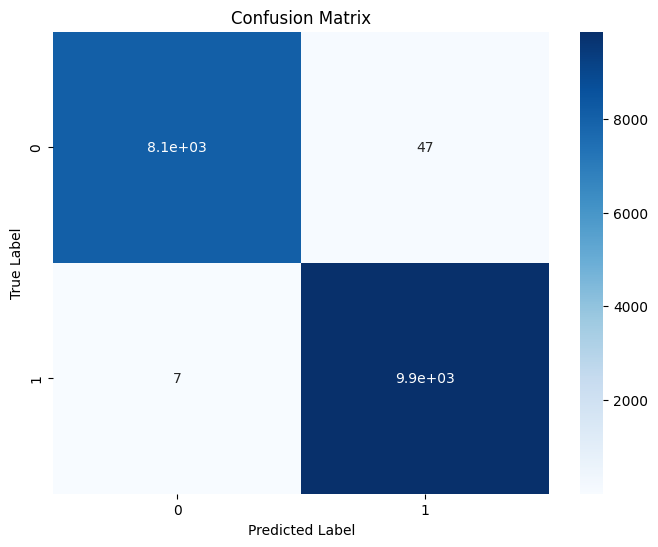

In [30]:
preds_and_labels = predictions.select("prediction", "isPoisonous")
preds_and_labels_rdd = preds_and_labels.rdd.map((lambda x: (float(x['prediction']), float(x['isPoisonous']))))

metrics = MulticlassMetrics(preds_and_labels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()
print(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()